In [49]:
# We need to install two specific packages to handles graphs:
!pip install networkx
!pip install pgmpy

In [50]:

import networkx as nx
from pgmpy.base.DAG import DAG
import matplotlib.pyplot as plt
import pandas as pd


In this practical session, we will cover the following topics:
- Graph Generation and Plotting
- Simulation studies for common causal fallacies
  - Fork paths
  - Collider bias

# Graph Generation and Plotting

The following DAG is due to Judea Pearl.
We will use it to illustrate how to generate a graph and plot it.
We will also show how to compute the ancestors and descendants of a node.

In [51]:
digraph = nx.DiGraph(
    [
        ("Z1", "X1"),
        ("X1", "D"),
        ("Z1", "X2"),
        ("Z2", "X3"),
        ("X3", "Y"),
        ("Z2", "X2"),
        ("X2", "Y"),
        ("X2", "D"),
        ("M", "Y"),
        ("D", "M")
    ]
)

In [52]:
G = DAG(digraph)

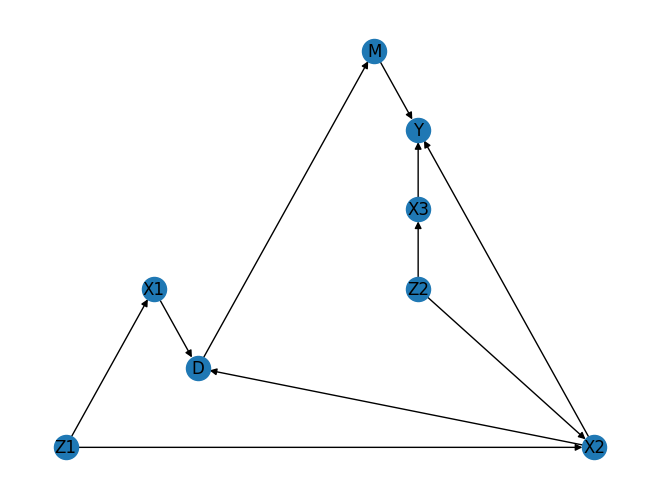

In [53]:
nx.draw_planar(G, with_labels=True)
plt.show()

In [54]:
print(list(G.predecessors("X2")))
print(list(G.successors("X2")))
print(list(nx.ancestors(G, "X2")))
print(list(nx.descendants(G, "X2")))

['Z1', 'Z2']
['Y', 'D']
['Z1', 'Z2']
['Y', 'D', 'M']


In [55]:
# Find Paths Between D and Y
list(nx.all_simple_paths(G.to_undirected(), "D", "Y"))

[['D', 'X1', 'Z1', 'X2', 'Y'],
 ['D', 'X1', 'Z1', 'X2', 'Z2', 'X3', 'Y'],
 ['D', 'M', 'Y'],
 ['D', 'X2', 'Y'],
 ['D', 'X2', 'Z2', 'X3', 'Y']]

In [56]:
# These returns all conditional independencies even among two sets of variables
# conditional on a third set
dseps = G.get_independencies()
# we display only the ones that correpond to pairs of singletons
for dsep in dseps.get_assertions():
    if len(dsep.get_assertion()[1]) == 1:
        print(dsep)

(Z2 ⟂ Y | X3, X2, M)
(X1 ⟂ X3)
(Z1 ⟂ M | D)
(X1 ⟂ Z2)
(M ⟂ X2 | D)
(Z1 ⟂ X3)
(X1 ⟂ Y | X2, X3, M)
(X1 ⟂ M | D)
(X1 ⟂ X2 | Z1)
(Y ⟂ D | X2, X3, M)
(Z1 ⟂ Y | X3, X2, M)
(X3 ⟂ X2 | Z2)
(Z2 ⟂ M | D)
(Z2 ⟂ D | X1, X2)
(Z1 ⟂ D | X1, X2)
(Z1 ⟂ Z2)
(X3 ⟂ M | Z2)
(D ⟂ X3 | Z2)


# Simulation studies

## A fork of icecream under the sun

[Credits to Prof. Reza Arghandeh](https://github.com/Ci2Lab/Applied_Causal_Inference_Course/blob/main/lectures/CH-3-Graphical-Causal-Models.ipynb)

In hot summer months, people tend to consume more ice cream and are also more
likely to get sunburns. While it might seem that Ice Cream Consumption (I) and
 Number of Sunburns (S) are related, this relationship is actually driven by a
third variable, Hot Temperature (H).

### Causal graph for icecream and sunburns

- TODO: Draw the causal graph corresponding to the causal relationships
between these variables.

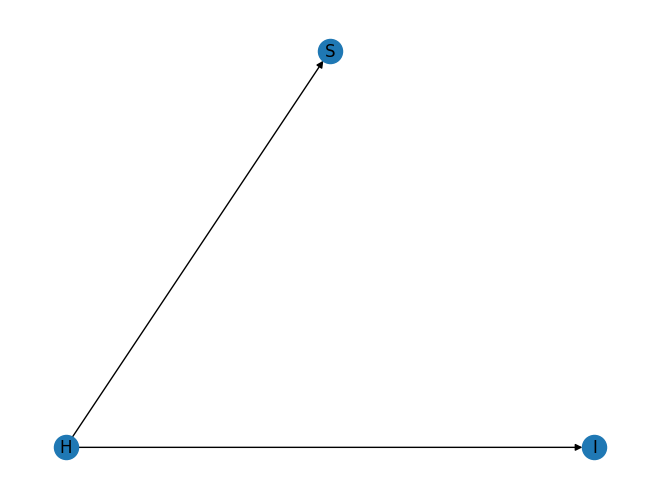

In [57]:
# CODE HERE

ice_cream_consumption = nx.DiGraph(
    [
        ("H", "I"),
        ("H", "S"),
    ]
)

DAG = DAG(ice_cream_consumption)

nx.draw_planar(DAG, with_labels=True)
plt.show()


### Simulate the data for icecream and sunburns
Let's generate synthetic data for the three variables:

In [58]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Set seed for reproducibility
np.random.seed(42)

# Simulating Hot Temperature (T)
hot_temperature = np.random.normal(
    loc=30, scale=5, size=100
)  # Average temperature of 30 degrees with some variation

# Simulating Ice Cream Consumption (I) based on Temperature (T)
ice_cream_consumption = 2 * hot_temperature + np.random.normal(
    loc=0, scale=5, size=100
)  # Higher temperature, more ice cream

# Simulating Number of Sunburns (S) based on Temperature (T)
number_of_sunburns = 1.5 * hot_temperature + np.random.normal(
    loc=0, scale=3, size=100
)  # Higher temperature, more sunburns

# Creating a DataFrame for the data
data = pd.DataFrame(
    {
        "hot_temperature": hot_temperature,
        "ice_cream_consumption": ice_cream_consumption,
        "number_sunburns": number_of_sunburns,
    }
)

# Display the first few rows of the dataset
data.head()

,hot_temperature,ice_cream_consumption,number_sunburns
0,32.483571,57.890288,49.798718
1,29.308678,56.514130,45.645371
2,33.238443,64.763313,53.106818
3,37.615149,71.218912,59.584130
4,28.829233,56.852038,39.110842


### Visualize the relationships between icecream and sunburns
We now use a scatter plot matrix to visualize the pairwise relationships
between Hot Temperature, Ice Cream Consumption, and Number of Sunburns.
- TODO: Visualize the scatter plot matrix for the data. You can use the
pairplot function from seaborn.

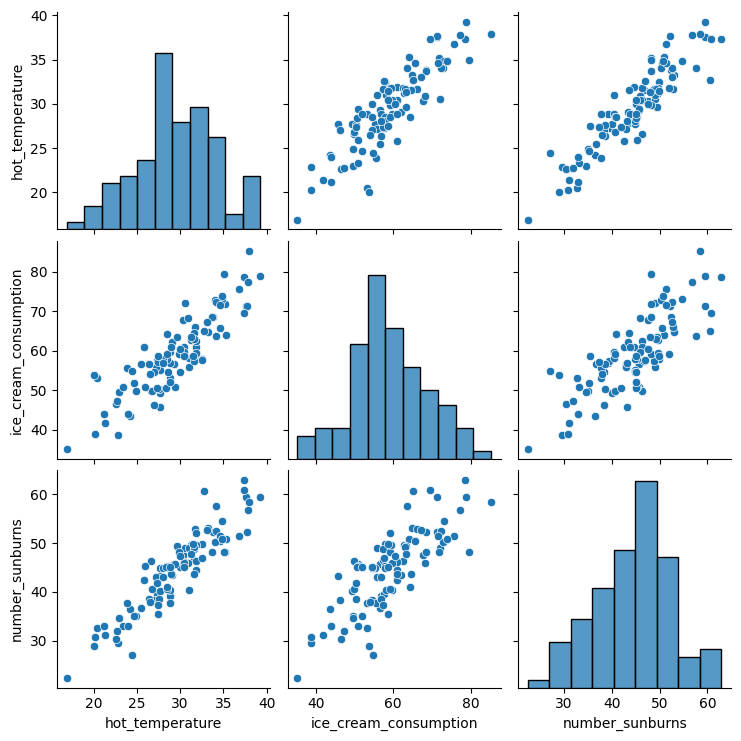

In [59]:
# CODE HERE
import seaborn as sb

sb.pairplot(data)

### Regression analysis for icecream and sunburns
First let's begin by a naive regression analysis between Ice Cream Consumption
 and Number of Sunburns.

In [60]:
import statsmodels.formula.api as smf

# Resizualized with Hot Temperature
naive_fit = smf.ols("number_sunburns ~ ice_cream_consumption", data).fit()
print(naive_fit.summary())

                            OLS Regression Results                            
Dep. Variable:        number_sunburns   R-squared:                       0.639
Model:                            OLS   Adj. R-squared:                  0.635
Method:                 Least Squares   F-statistic:                     173.6
Date:                Tue, 10 Feb 2026   Prob (F-statistic):           2.04e-23
Time:                        09:48:07   Log-Likelihood:                -299.48
No. Observations:                 100   AIC:                             603.0
Df Residuals:                      98   BIC:                             608.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                 4.88

We see that the coefficient for ice_cream_consumption is positive and
statistically significant. This might lead us to believe that ice cream
consumption causes sunburns. However, this is not the case. The relationship
 between ice cream consumption and sunburns is confounded by hot temperature.
 Let's see what happens when we control for hot temperature.

### Resizualized with Hot Temperature
- TODO: Perform a regression analysis for both the ice cream and the number of
 sun burns to *regress away* the effect of the hot_temperature.
Regression for ice_cream_consumption

In [61]:
# CODE HERE
ice_cream_fit = smf.ols("number_sunburns ~ ice_cream_consumption + hot_temperature", data).fit()
print(ice_cream_fit.summary())

                            OLS Regression Results                            
Dep. Variable:        number_sunburns   R-squared:                       0.844
Model:                            OLS   Adj. R-squared:                  0.841
Method:                 Least Squares   F-statistic:                     262.8
Date:                Tue, 10 Feb 2026   Prob (F-statistic):           6.92e-40
Time:                        09:48:10   Log-Likelihood:                -257.48
No. Observations:                 100   AIC:                             521.0
Df Residuals:                      97   BIC:                             528.8
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                -3.80

Lets's vizualize the debiased data.

In [62]:
import statsmodels.formula.api as smf

# Calculate residuals by regressing out the effect of hot_temperature
ice_cream_debiased = smf.ols("ice_cream_consumption ~ hot_temperature", data).fit().resid
sunburns_debiased = smf.ols("number_sunburns ~ hot_temperature", data).fit().resid

residuals_data = pd.DataFrame(
    {
        "ice_cream_residuals": ice_cream_debiased,
        "sunburns_residuals": sunburns_debiased,
    }
)

## Visualize the residuals (relationship after conditioning)

In [63]:
# CODE HERE
print(residuals_data)

    ice_cream_residuals  sunburns_residuals
0             -6.758204            0.468163
1             -2.239403            1.511191
2             -1.286782            2.540757
3             -2.957601            1.854675
4             -1.011288           -4.238626
..                  ...                 ...
95             0.841153           -1.344024
96            -4.244320            2.230716
97             0.918477            0.477783
98             0.257567            2.169419
99            -5.920022            1.783565

[100 rows x 2 columns]


## Debiased regression

In [64]:
print(
    smf.ols("sunburns_residuals ~ ice_cream_residuals", residuals_data).fit().summary()
)

                            OLS Regression Results                            
Dep. Variable:     sunburns_residuals   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.010
Method:                 Least Squares   F-statistic:                   0.01164
Date:                Tue, 10 Feb 2026   Prob (F-statistic):              0.914
Time:                        09:48:16   Log-Likelihood:                -257.48
No. Observations:                 100   AIC:                             519.0
Df Residuals:                      98   BIC:                             524.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept           -1.742e-14    

TODO: What do you observe in the debiased regression analysis? WHat value do the coefficient of ice_cream_residuals take? What does it suggest for the relationship between ice cream consumption and number of sunburns?

# Collider bias for celebrities at Hollywood

Here is a simple example to illustate the collider or M-bias.
Credits to [Chernozhulov et al., 2024, Causal ML book](https://www.causalml-book.org/).

The idea is that people who get to Hollywood tend to have a high
congenility = talent + beauty. Funnily enough this induces a negative
correlation between talents and looks, when we condition on the set of actors
or celebrities.

This simple example explains an anecdotal observation that "talent and beauty
are negatively correlated" for celebrities.
This is a form of collider bias, also coined as selection bias for this specific case.

### Causal graph for celebrities at Hollywood

- TODO: Draw the graph the graph corresponding to the causal relationships between these variables.

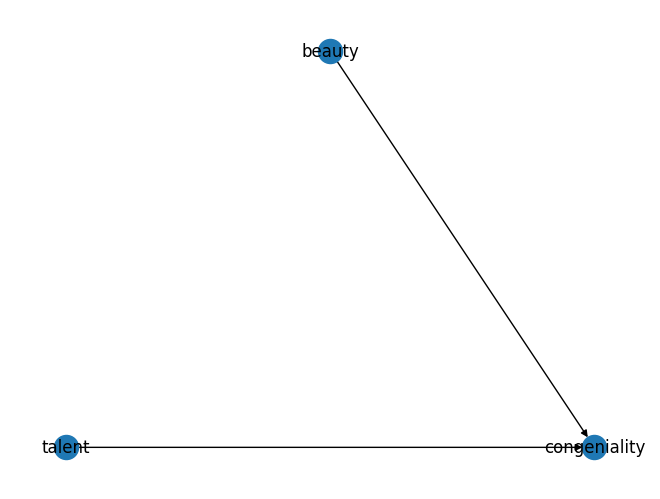

In [69]:
# CODE HERE

from pgmpy.base.DAG import DAG

celebrities = nx.DiGraph(
    [
        ("talent", "congeniality"),
        ("beauty", "congeniality"),
    ]
)

DAG = DAG(celebrities)

nx.draw_planar(DAG, with_labels=True)
plt.show()

### Simulate the data for celebrities at Hollywood

In [70]:
np.random.seed(123)
num_samples = 10000
talent = np.random.normal(size=num_samples)
beauty = np.random.normal(size=num_samples)
congeniality = talent + beauty + np.random.normal(size=num_samples)  # congeniality
hollywood_data = pd.DataFrame(
    {
        "talent": talent,
        "beauty": beauty,
        "congeniality": congeniality,
    }
)
# Create the conditional variable: celebrity is True if congeniality > 2
hollywood_data["celebrity"] = hollywood_data["congeniality"] > 2

### Visualize the relationships for celebrities at Hollywood
- TODO: Visualize the pairplot :
 - for the whole data.
 - only for the celebrities.

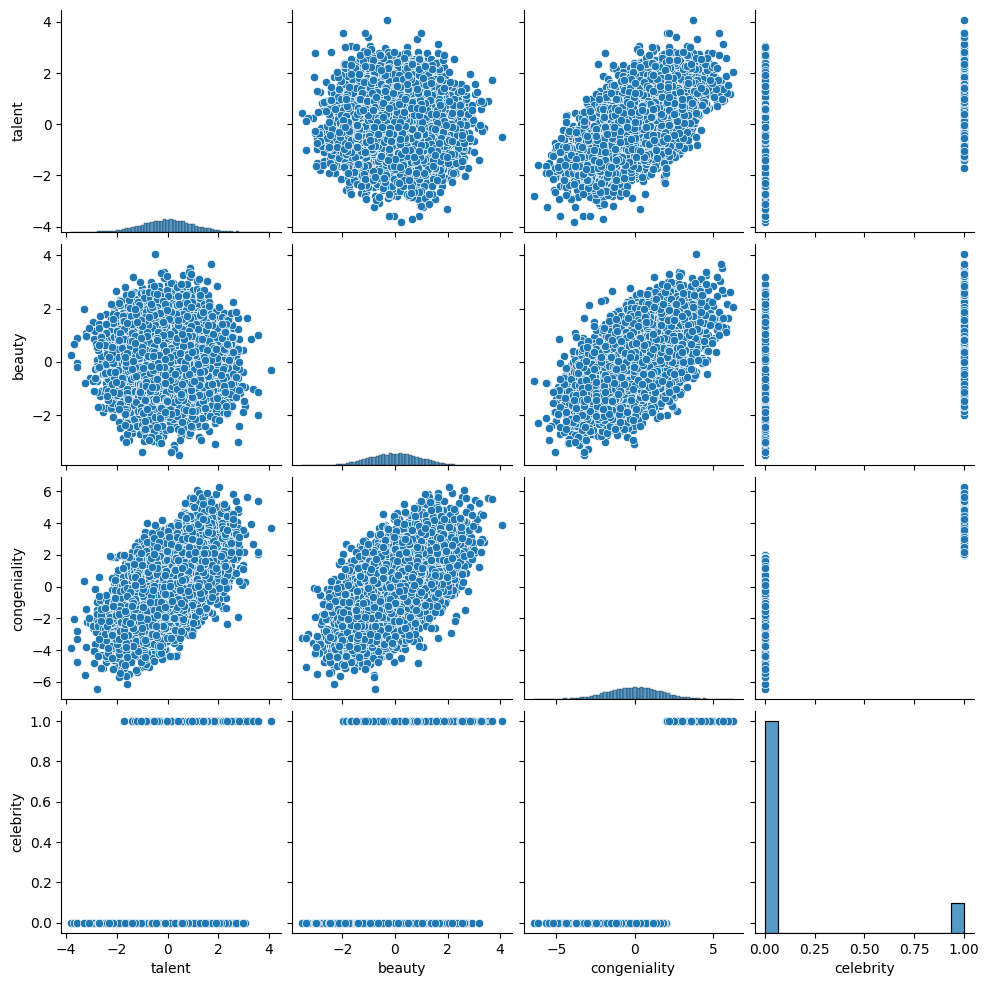

In [77]:
# CODE HERE

print(sb.pairplot(hollywood_data))


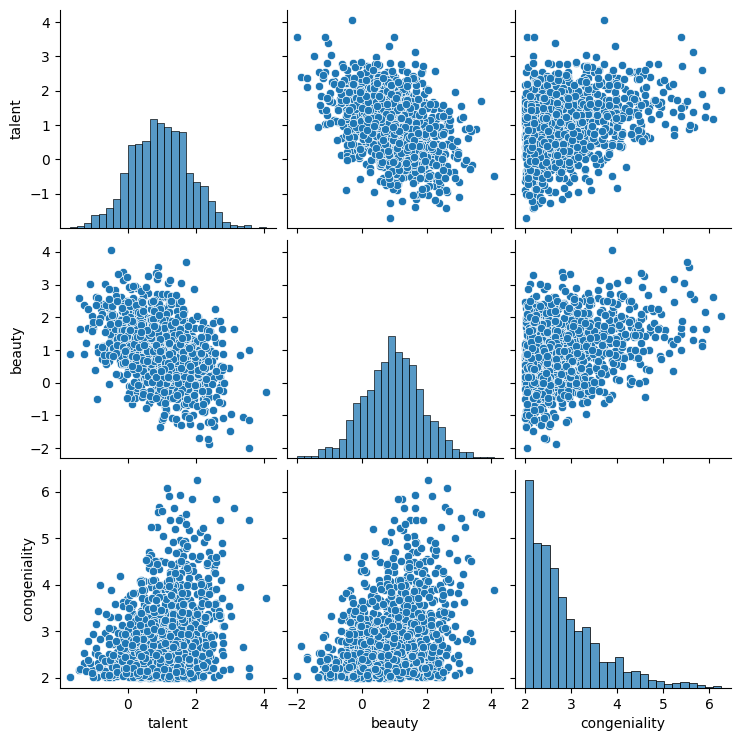

In [78]:
print(sb.pairplot(hollywood_data[hollywood_data["celebrity"] == True].drop(columns=['celebrity'])))

We see that for the whole data, there is no correlation between talent and
beauty. However, when we condition on the set of celebrities, we see a
negative correlation between talent and beauty. This is an example of collider
bias.

### Regression analysis for celebrities at Hollywood
Recover what we have seen in the pairplot, that is, the negative correlation
between talent and beauty for celebrities.
- TODO: Perform regression analysis to show the collider bias. You should
contrast a regression analysis for the whole data and for the celebrities only.

In [79]:
# CODE HERE

print(smf.ols("beauty ~ talent", hollywood_data).fit().summary())

                            OLS Regression Results                            
Dep. Variable:                 beauty   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.2987
Date:                Tue, 10 Feb 2026   Prob (F-statistic):              0.585
Time:                        10:03:50   Log-Likelihood:                -14215.
No. Observations:               10000   AIC:                         2.843e+04
Df Residuals:                    9998   BIC:                         2.845e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0103      0.010      1.030      0.3

In [86]:
unbiased_beauty = smf.ols("beauty ~ celebrity", hollywood_data).fit().resid
unbiased_talent = smf.ols("talent ~ celebrity", hollywood_data).fit().resid

unbiased_data = pd.DataFrame(
    { "unbiased_beauty": unbiased_beauty,
      "unbiased_talent": unbiased_talent,
    }
)

print(smf.ols("unbiased_beauty ~ unbiased_talent", unbiased_data).fit().summary())

                            OLS Regression Results                            
Dep. Variable:        unbiased_beauty   R-squared:                       0.019
Model:                            OLS   Adj. R-squared:                  0.019
Method:                 Least Squares   F-statistic:                     197.2
Date:                Tue, 10 Feb 2026   Prob (F-statistic):           2.22e-44
Time:                        10:08:51   Log-Likelihood:                -13440.
No. Observations:               10000   AIC:                         2.688e+04
Df Residuals:                    9998   BIC:                         2.690e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept        5.031e-17      0.009   5.